In [2]:
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir + '/src')

In [26]:
import numpy as np
import pandas as pd
from demos import prepare_data

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
wheater_path = repo.working_tree_dir + '/data/wheater_data.csv'
revenue_path = repo.working_tree_dir + '/data/revenue_data.csv'
df = prepare_data(wheater_path, revenue_path)

/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Restaurant-Revenue-Forecasting/src/demos.py:66: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.yesterday_revenue.iloc[0] = df.revenue.iloc[0]
/Users/jonasfischer/Librar

In [118]:
df.tail(10)

,tavg,tmin,tmax,prcp,wdir,wspd,pres,national_holiday,holiday,revenue,weekday,holiday_not_bw,DOW,yesterday_revenue,three_day_revenue,week_revenue
date,,,,,,,,,,,,,,,,
2024-07-07,16.7,10.3,21.6,0.0,202,8.2,1014.7,False,False,5457,sunday,False,6,4629.0,3090.666667,2765.142857
2024-07-08,19.1,12.2,25.1,0.0,113,7.1,1017.2,False,False,2448,monday,False,0,5457.0,4136.000000,2906.857143
2024-07-09,23.7,16.2,30.8,0.0,109,9.3,1015.5,False,False,1690,tuesday,False,1,2448.0,4178.000000,2937.000000
2024-07-10,21.8,19.3,25.6,4.3,204,10.4,1016.2,False,False,2186,wednesday,False,2,1690.0,3198.333333,2918.142857
2024-07-11,21.4,17.6,25.3,0.9,255,7.1,1017.4,False,False,1703,thursday,False,3,2186.0,2108.000000,3007.571429
2024-07-12,21.5,17.8,26.0,23.6,188,12.0,1011.1,False,False,2472,friday,False,4,1703.0,1859.666667,2919.285714
2024-07-13,17.9,13.2,21.6,0.0,273,9.0,1013.7,False,False,5098,saturday,False,5,2472.0,2120.333333,2940.714286
2024-07-14,19.3,13.2,24.2,0.0,197,7.7,1014.3,False,False,5235,sunday,False,6,5098.0,3091.000000,3007.714286
2024-07-15,22.8,16.0,29.3,2.7,108,7.2,1012.0,False,False,1548,monday,False,0,5235.0,4268.333333,2976.000000


In [87]:
df.tail(10)

,tavg,tmin,tmax,prcp,wdir,wspd,pres,national_holiday,holiday,revenue,...,DOW,yesterday_revenue,lag2,lag3,lag4,lag5,lag6,lag7,three_day_revenue,week_revenue
date,,,,,,,,,,,,,,,,,,,,,
2024-07-07,16.7,10.3,21.6,0.0,202,8.2,1014.7,False,False,5457,...,6,4629.0,2322.0,2321.0,1560.0,1822.0,2237.0,4465.0,NaN,NaN
2024-07-08,19.1,12.2,25.1,0.0,113,7.1,1017.2,False,False,2448,...,0,5457.0,4629.0,2322.0,2321.0,1560.0,1822.0,2237.0,NaN,NaN
2024-07-09,23.7,16.2,30.8,0.0,109,9.3,1015.5,False,False,1690,...,1,2448.0,5457.0,4629.0,2322.0,2321.0,1560.0,1822.0,NaN,NaN
2024-07-10,21.8,19.3,25.6,4.3,204,10.4,1016.2,False,False,2186,...,2,1690.0,2448.0,5457.0,4629.0,2322.0,2321.0,1560.0,NaN,NaN
2024-07-11,21.4,17.6,25.3,0.9,255,7.1,1017.4,False,False,1703,...,3,2186.0,1690.0,2448.0,5457.0,4629.0,2322.0,2321.0,NaN,NaN
2024-07-12,21.5,17.8,26.0,23.6,188,12.0,1011.1,False,False,2472,...,4,1703.0,2186.0,1690.0,2448.0,5457.0,4629.0,2322.0,NaN,NaN
2024-07-13,17.9,13.2,21.6,0.0,273,9.0,1013.7,False,False,5098,...,5,2472.0,1703.0,2186.0,1690.0,2448.0,5457.0,4629.0,NaN,NaN
2024-07-14,19.3,13.2,24.2,0.0,197,7.7,1014.3,False,False,5235,...,6,5098.0,2472.0,1703.0,2186.0,1690.0,2448.0,5457.0,NaN,NaN
2024-07-15,22.8,16.0,29.3,2.7,108,7.2,1012.0,False,False,1548,...,0,5235.0,5098.0,2472.0,1703.0,2186.0,1690.0,2448.0,NaN,NaN


In [28]:
df_weekday = df[['weekday', 'revenue','DOW']]

<Axes: xlabel='weekday'>

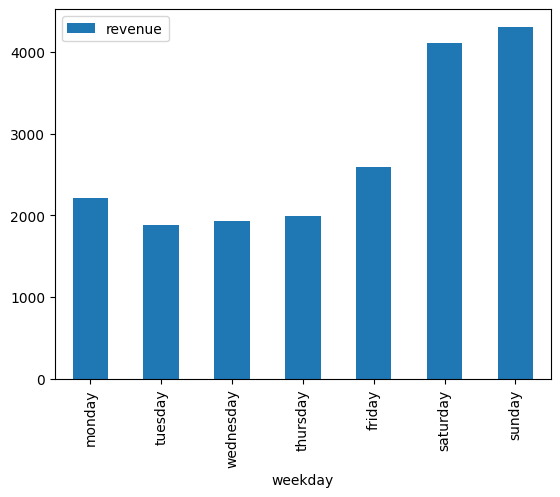

In [31]:
revenue_per_day = df_weekday.groupby('weekday').mean().sort_values(by=['DOW'])
revenue_per_day.plot.bar(y='revenue')

In [46]:
df.sort_values(by=['revenue'], ascending=False).head(10)

,tavg,tmin,tmax,prcp,wdir,wspd,pres,national_holiday,holiday,revenue,weekday,holiday_not_bw,DOW
date,,,,,,,,,,,,,
2024-06-23,17.9,11.8,23.0,0.0,40,6.8,1018.3,False,False,6300,sunday,False,6
2024-05-12,18.6,11.7,24.2,0.0,97,12.3,1016.8,False,False,6147,sunday,False,6
2023-07-23,21.8,16.5,27.2,0.0,216,17.3,1012.3,False,False,5668,sunday,False,6
2024-06-16,16.8,12.6,21.5,0.0,216,14.0,1011.1,False,False,5546,sunday,False,6
2024-07-07,16.7,10.3,21.6,0.0,202,8.2,1014.7,False,False,5457,sunday,False,6
2023-07-09,27.8,19.5,34.6,0.0,107,7.2,1019.1,False,False,5390,sunday,False,6
2023-05-29,20.0,13.5,25.3,0.0,54,15.5,1018.3,True,False,5331,monday,True,0
2024-06-09,17.3,12.4,21.2,0.0,343,11.2,1009.5,False,False,5311,sunday,False,6
2024-05-20,16.2,9.9,22.1,0.0,132,5.2,1010.4,True,True,5296,monday,True,0


In [48]:
df['revenue'].shift(-1)

date
2022-06-01    1641.0
2022-06-02    2254.0
2022-06-03    4306.0
2022-06-04    4289.0
2022-06-05    4884.0
               ...  
2024-07-12    5098.0
2024-07-13    5235.0
2024-07-14    1548.0
2024-07-15    2183.0
2024-07-16       NaN
Name: revenue, Length: 777, dtype: float64

In [34]:
df.to_pickle(repo.working_dir + '/data/dataframe.pkl')